In [1]:
!pip install session-info
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 3.5 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8046 sha256=b6147cb2426867f8dc57a3a891537672d3e2b5315e03d5fc0ad53d51d80a1568
  Stored in directory: /root/.cache/pip/wheels/5c/1b/4d/111d73980c5c6a8e5e5905a19eccc34296cb359cac54c6c5b9
Successfully built session-info
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 11.

In [2]:
import tensorflow as tf
print(tf.__version__) # Verificar 2.9.0

2.9.0


In [23]:
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf 
from tensorflow import keras
from keras.layers import Input, Dense, Add
from keras.utils.vis_utils import plot_model

from numpy.linalg import norm
import pandas as pd

import sklearn.metrics

from keras import regularizers as l 

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import os

from matplotlib.ticker import FormatStrFormatter

import time
from scipy import interpolate

In [4]:
print(os.getcwd())

/content


In [7]:
os.chdir('/content/drive/MyDrive/Tesis Maestría /Codigos depurados/LPAR/ExperimentoB')
print(os.getcwd())

/content/drive/MyDrive/Tesis Maestría /Codigos depurados/LPAR/ExperimentoB


In [8]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [9]:
def load_data():
  mnist = keras.datasets.fashion_mnist
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train, X_test = X_train / 255.0, X_test / 255.0
  X_train = X_train.reshape(len(y_train),784)
  X_test  = X_test.reshape(len(y_test),784)

  y_train_onehot = keras.utils.to_categorical(y_train)
  y_test_onehot =  keras.utils.to_categorical(y_test)

  print(f'Conjunto de datos cargados')
  print(f'Tamaño imágenes de entrenamiento {X_train[:10000].shape}')
  print(f'Tamaño imágenes de test {X_test.shape}')
  print(f'Datos por cada etiqueta en X train {np.bincount(y_train[:10000])}')
  return X_train[:10000], X_test, y_train_onehot[:10000], y_test_onehot, y_train[:10000], y_test

In [10]:
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = load_data()

4422102/4422102 [==============================] - 0s 0us/step
Conjunto de datos cargados
Tamaño imágenes de entrenamiento (10000, 784)
Tamaño imágenes de test (10000, 784)
Datos por cada etiqueta en X train [ 942 1027 1016 1019  974  989 1021 1022  990 1000]


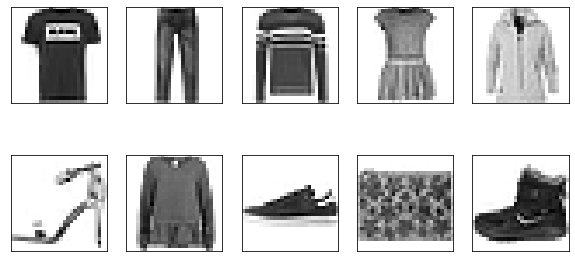

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='gist_yarg')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

## Modelo con $n$ saltos residuales

In [12]:
def skip_conection(dense_input, n, regular_l):
  if n >= 2:
    resDense = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
    return skip_conection(Add()([dense_input, resDense]), n-1, regular_l)
  resDenseo = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
  return Add()([dense_input, resDenseo])

In [13]:
def load_model(n, regular_l):
  keras.backend.clear_session()
  inputs  = Input(shape=(784,))
  dense1  = Dense(20, activation  ='relu', kernel_regularizer=regular_l)(inputs)
  
  skip_final = skip_conection(dense1, n, regular_l)

  outputs = Dense(10, activation='sigmoid', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=100, shuffle=True):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_array)//self.batch_size

    def __getitem__(self, index):
        keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]
        x = np.asarray(self.images[keys], dtype=np.float32)
        y = np.asarray(self.labels[keys], dtype=np.float32)
      
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            self.key_array = np.random.permutation(self.key_array)

In [15]:
generator = DataGenerator(images=X_train, labels=y_train, batch_size=100, shuffle=True)
n_batches = len(generator)
n_batches

100

In [16]:
def lipschitz_bound(modelWeigts):
  numberLayers = len(modelWeigts)
  LipsBound = np.linalg.norm(modelWeigts[0], ord=2)     # Norma espectral (2) capa 1
  if LipsBound == 0: LipsBound = 1

  for rc in np.arange(2,numberLayers-2,2):              # En los indices de las capas residuales
    try: 
      LipsBound *= (1 + np.linalg.norm(modelWeigts[rc], ord=2))
    except:
      LipsBound *= 1
  
  LipsBound *= np.linalg.norm(modelWeigts[numberLayers-2], ord=2) # Capa de salida

  return  LipsBound

##  Funciones graficar 

In [17]:
def graphGridAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Training Accuracy', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ Training Accuracy',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ Validation Accuracy',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'Accuracy',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  plt.grid()
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.tight_layout()
  nameFile = 'presicionModelo' + str(skip) + 'G' +'.pdf'
  #plt.savefig(nameFile) 
  #plt.show()



def graphAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Training Accuracy', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ Training Accuracy',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ Validation Accuracy',
                  alpha=0.2, color = '#ff5271')
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  #plt.legend(fontsize=36, loc ='lower right')
  #plt.savefig(nameFile) 
  #plt.show()


In [18]:
def graphGridLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ Lipschitz Bound')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  nameFile = 'cotaLipschitzModelo' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ Lipschitz Bound')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelo' + str(skip) +'.pdf'
  plt.savefig(nameFile) 
  #plt.show()

In [19]:
def graphGridLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ Lipschitz Bound')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelolog' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  #plt.savefig(nameFile) 
  #plt.show()

def graphLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Lipschitz Bound', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ Lipschitz Bound')

  plt.xlabel('Epoch',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  nameFile = 'cotaLipschitzModelolog' + str(skip) +'.pdf'
  plt.tight_layout()
  #plt.savefig(nameFile) 
  #plt.show()

In [20]:
def graphGridLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  plt.grid()
  nameFile = 'funcionPerdidaModelo' + str(skip) + 'G' + '.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  nameFile = 'funcionPerdidaModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización Alternante cota Lipschitz

In [21]:
class CustomLoss(keras.losses.Loss):
    def __init__(self, Model = None, name="adaptativeRegularLB"):
        super().__init__(name=name)
        self.Model = Model

    def call(self, y_true, y_pred):
        self.Model._callable_losses.clear()
        cce = tf.keras.losses.CategoricalCrossentropy()
        loss = tf.cast(cce(y_true, y_pred), "float32")
        self.eig_values_radom(self.Model)
        loss += sum(self.Model.losses)
        return  loss 

    def eig_values_radom(self, Model):
      allLayers = self.Model.layers
      nLayers = len(allLayers)
      randomLayer = np.random.choice(np.append([1], [np.arange(2,nLayers,2)]), size=1)[0]
      EigVal = np.linalg.norm(allLayers[randomLayer].get_weights()[0], ord=2)
      self.Model.add_loss(lambda: EigVal*tf.norm(allLayers[randomLayer].trainable_variables[0], ord=2))
      return 

In [24]:
skips = [3,5,7]
n_epochs = 60
resultGeneral = {}
for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []
  
  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,l.l2(0))

    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          lossC = CustomLoss(Model = model)
          loss = lossC(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()

      y_ = model(X_train[test_index]) # Validation predictions
      loss_val[epoch] = ce_loss(y_true=y_train_onehot[test_index], y_pred=y_).numpy()
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.argmax(y_, axis=-1))

    
      LB = lipschitz_bound(model.get_weights())
      
      LB_1[epoch]= LB



    y_test_ = model(X_test)
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1)))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  # Diference train and validation
  diff_acc_mean = np.mean(acc_train_mean_M0 - acc_val_mean_M0)
  print('Mean diference train and validation')
  print(diff_acc_mean)
   
  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0
  # Area std train
  print('Area std train ')
  area_std_train = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_train_std_M0, k=1).integral(0,1)
  print(area_std_train)

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0
  # Area std test
  print('Area std test')
  area_std_test = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_val_std_M0, k=1).integral(0,1)
  print(area_std_test)

  # graphGridAcc(skip)
  # graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  # graphGridLipschtiz(skip)
  # graphLipschtiz(skip)
  # graphGridLipschtizlog(skip)
  # graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  # graphGridLoss(skip)
  # graphLoss(skip)

  resultGeneral[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, 
                         Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneral), 'ResultadosExperimentoALB.csv')


Modelo : 3 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 181.75647521018982 en k-fold 1
80
Tiempo total 183.54686427116394 en k-fold 2
80
Tiempo total 180.83463501930237 en k-fold 3
80
Tiempo total 180.15531611442566 en k-fold 4
80
Tiempo total 180.09528231620789 en k-fold 5
Mean diference train and validation
-0.0020824681385358157
Area std train 
0.0758738350123167
Area std test
0.08414792936478953
Modelo : 5 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 198.2204465866089 en k-fold 1
80
Tiempo total 198.54664087295532 en k-fold 2
80
Tiempo total 200.72718262672424 en k-fold 3
80
Tiempo total 199.36176943778992 en k-fold 4
80
Tiempo total 199.69849848747253 en k-fold 5
Mean diference train and validation
0.0041121179191271374
Area std train 
0.13294455781579018
Area st

### Evaluación en test de los modelos 

In [25]:
for skip in skips:
  mean_test = np.mean(resultGeneral[skip][5])
  std_test = np.std(resultGeneral[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 3, test 77.38 +/- 0.318
Modelo 5, test 79.22 +/- 1.142
Modelo 7, test 81.39 +/- 0.254


### Evaluación en entrenamiento de los modelos

In [26]:
for skip in skips:
  mean_train = np.mean([resultGeneral[skip][0][x][-1] for x in resultGeneral[skip][0]])
  std_train = np.std([resultGeneral[skip][0][x][-1] for x in resultGeneral[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 3, train 78.42 +/- 0.645
Modelo 5, train 81.08 +/- 1.301
Modelo 7, train 83.56 +/- 0.363


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L2

### Sintonización hiper-parámetro

In [27]:
skips = [3,5,7]
kf = KFold(n_splits=5, shuffle=False)

In [28]:
param_grid = [ l.l2(0.1), l.l2(0.01), l.l2(0.001), l.l2(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l2}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_model(skip,param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train_onehot[train_index],
                epochs = 20, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 3, parametro 0.10000000149011612
Kfold 1 acc train 0.6850000023841858, acc test 0.6754999756813049
Kfold 2 acc train 0.706125020980835, acc test 0.6974999904632568
Kfold 3 acc train 0.6972500085830688, acc test 0.7074999809265137
Kfold 4 acc train 0.7316250205039978, acc test 0.7179999947547913
Kfold 5 acc train 0.7143750190734863, acc test 0.6965000033378601
Fin modelo: promedio acc train 0.7068750143051148,std 0.015751395176599504
Fin modelo: promedio acc test 0.6989999890327454,std 0.014099649863261718


Modelo 3, parametro 0.009999999776482582
Kfold 1 acc train 0.8323749899864197, acc test 0.8240000009536743
Kfold 2 acc train 0.8567500114440918, acc test 0.8245000243186951
Kfold 3 acc train 0.8456249833106995, acc test 0.8370000123977661
Kfold 4 acc train 0.8346250057220459, acc test 0.8054999709129333
Kfold 5 acc train 0.8429999947547913, acc test 0.8165000081062317
Fin modelo: promedio acc train 0.8424749970436096,std 0.008690300092833232
Fin modelo: promedio acc test 0.82

In [29]:
regularParameters = {3: l.l2(0.001), 5: l.l2(0.0001), 7: l.l2(0.0001)}
regularParameters

{3: <keras.regularizers.L2 at 0x7f4f143f4040>,
 5: <keras.regularizers.L2 at 0x7f4f143f4d90>,
 7: <keras.regularizers.L2 at 0x7f4f143f47f0>}

### Entrenamiento

Modelo : 3 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 140.27747774124146 en k-fold 1
80
Tiempo total 140.6350061893463 en k-fold 2
80
Tiempo total 141.15673923492432 en k-fold 3
80
Tiempo total 144.91390657424927 en k-fold 4
80
Tiempo total 144.02635955810547 en k-fold 5
Mean diference train and validation
0.014652958103021
Area std train 
0.017509693279862404
Area std test
0.037224179644296626
Modelo : 5 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 168.50041007995605 en k-fold 1
80
Tiempo total 169.6945288181305 en k-fold 2
80
Tiempo total 167.9295196533203 en k-fold 3
80
Tiempo total 170.8853931427002 en k-fold 4
80
Tiempo total 167.73881196975708 en k-fold 5
Mean diference train and validation
0.02113876056273778
Area std train 
0.07407449744641781
Area std test


<ipython-input-19-ae7bd233304b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-19-ae7bd233304b>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 12))
<ipython-input-20-f54571b893d2>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.f

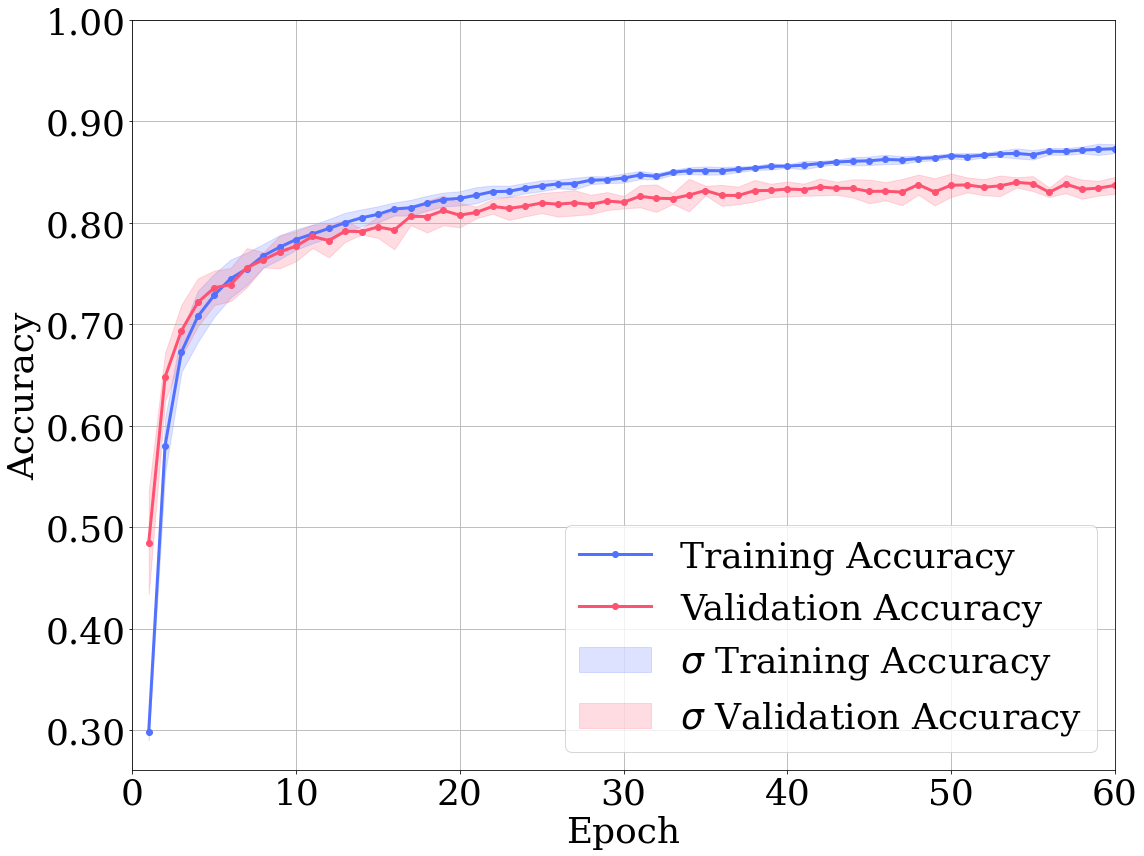

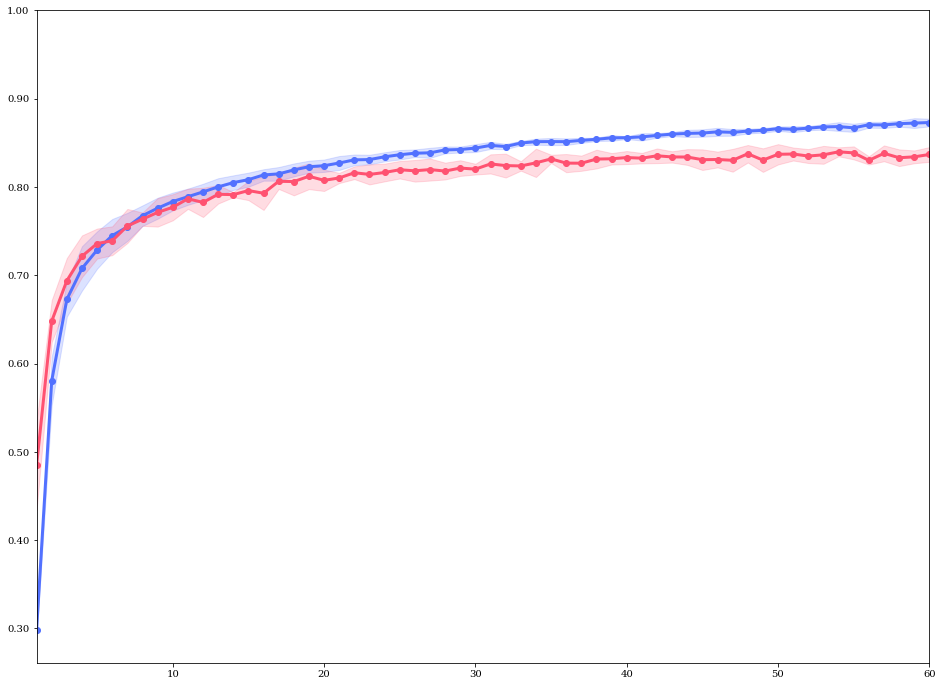

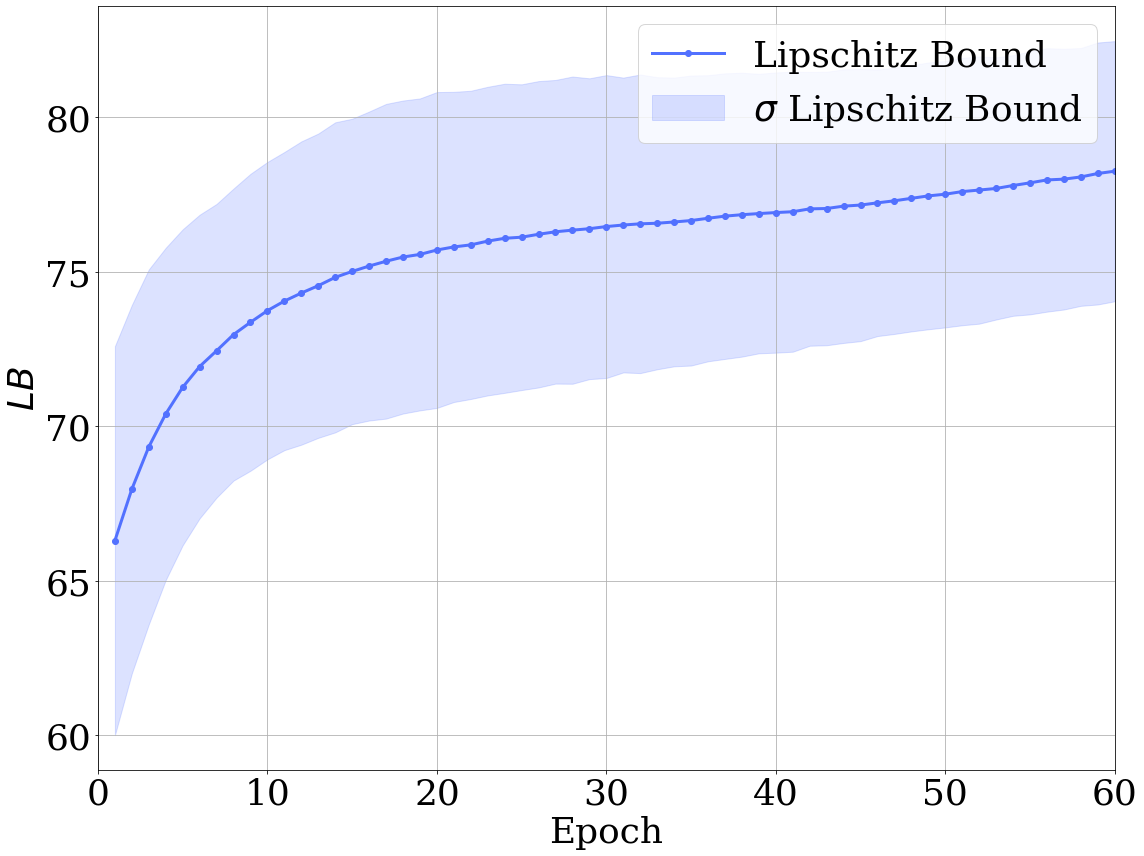

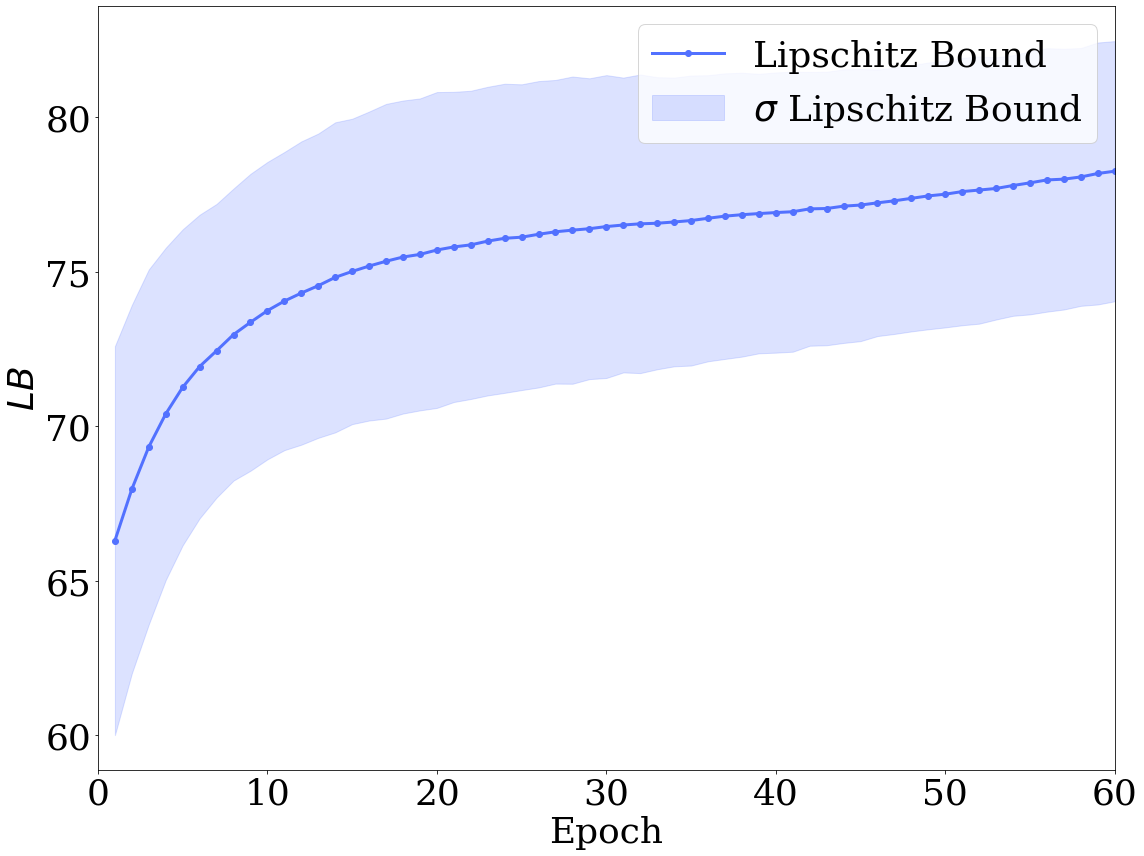

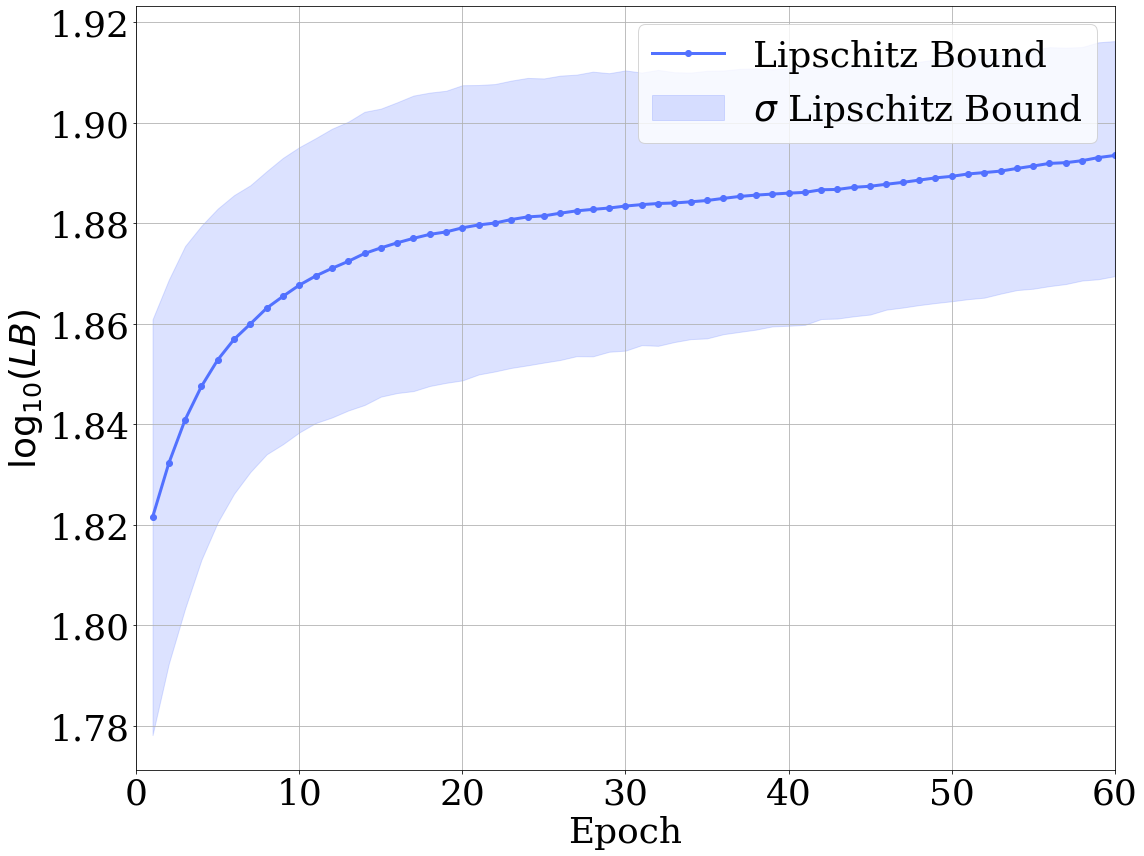

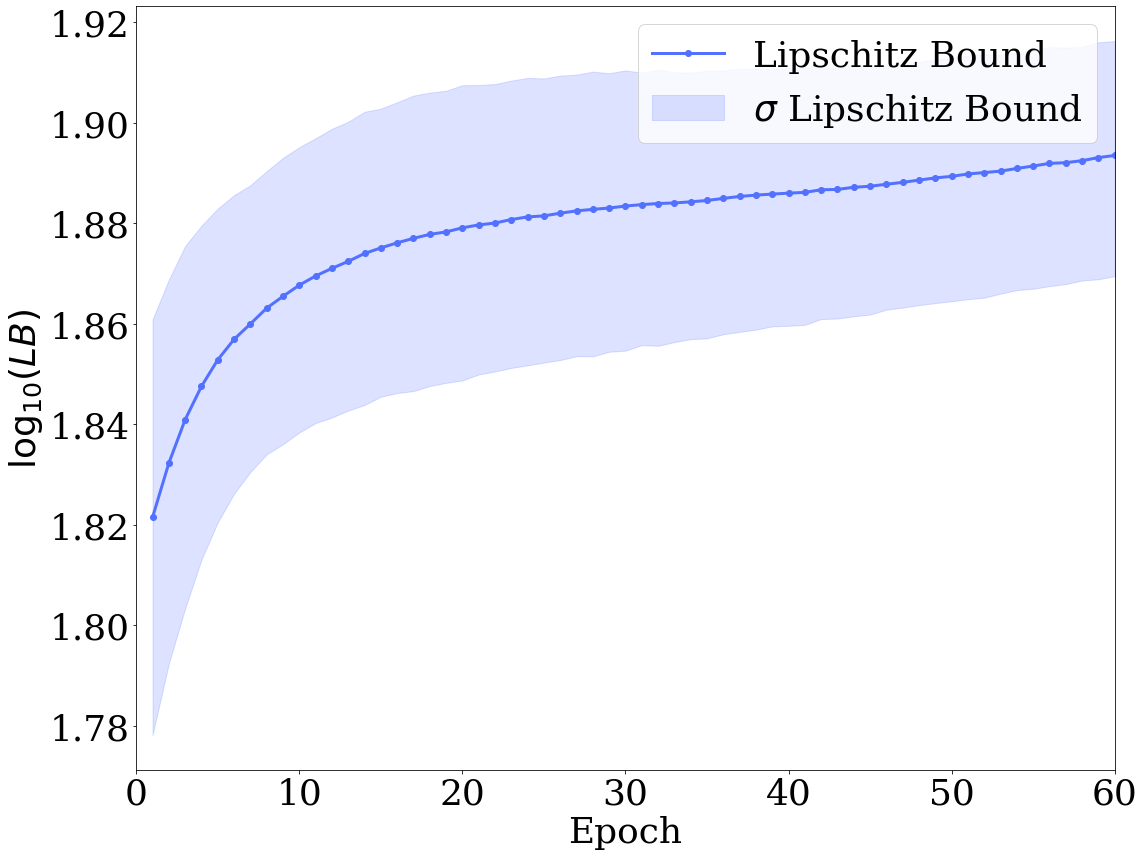

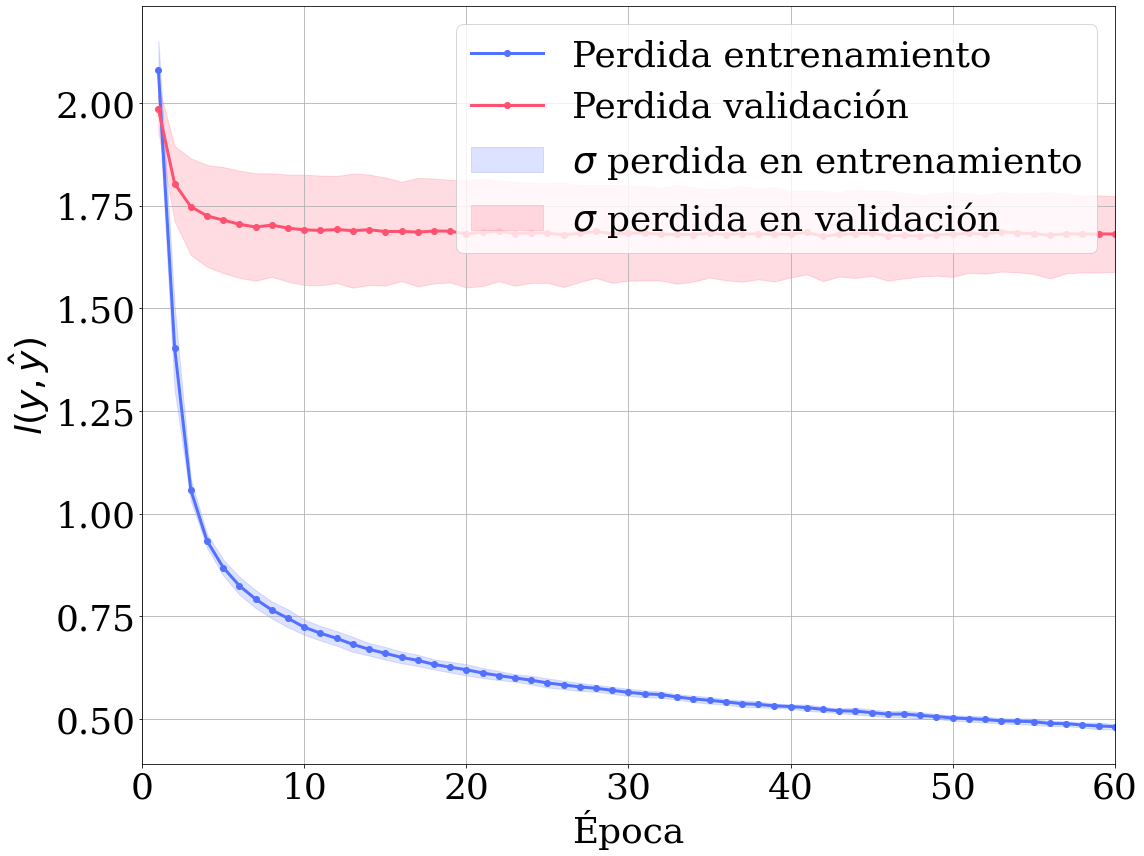

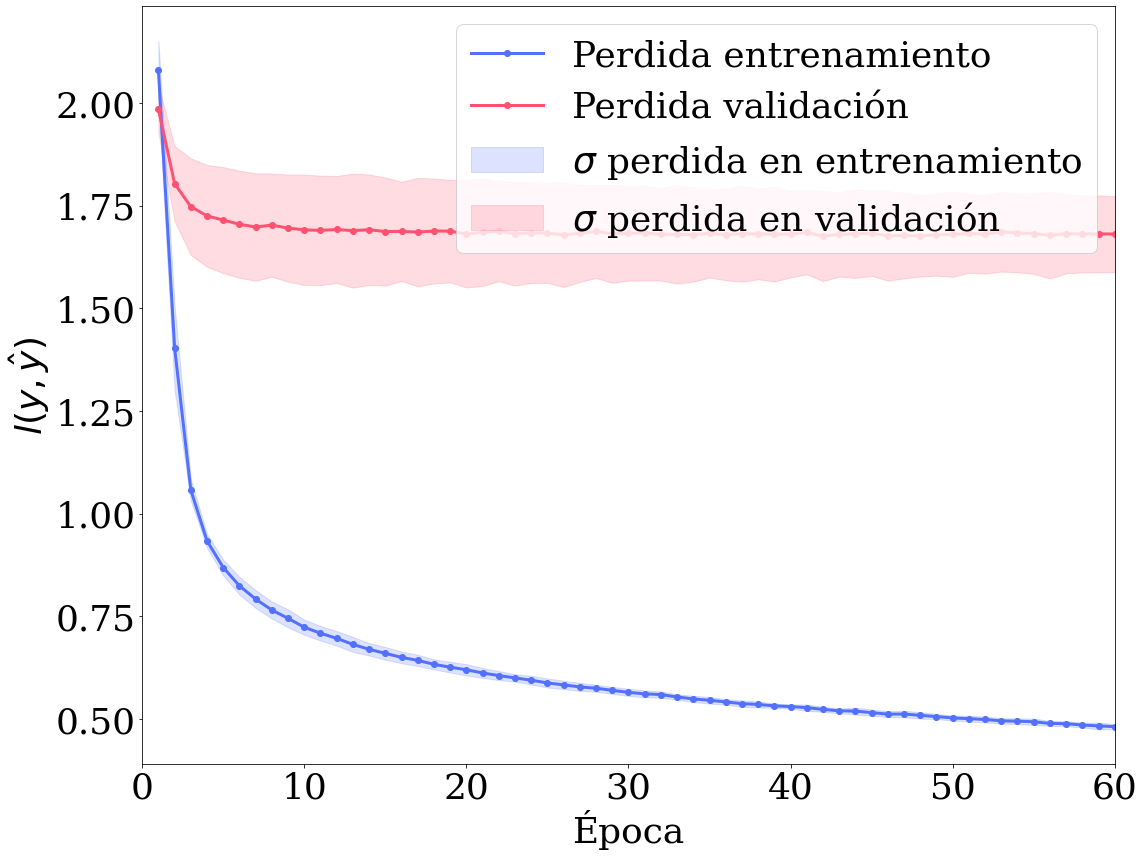

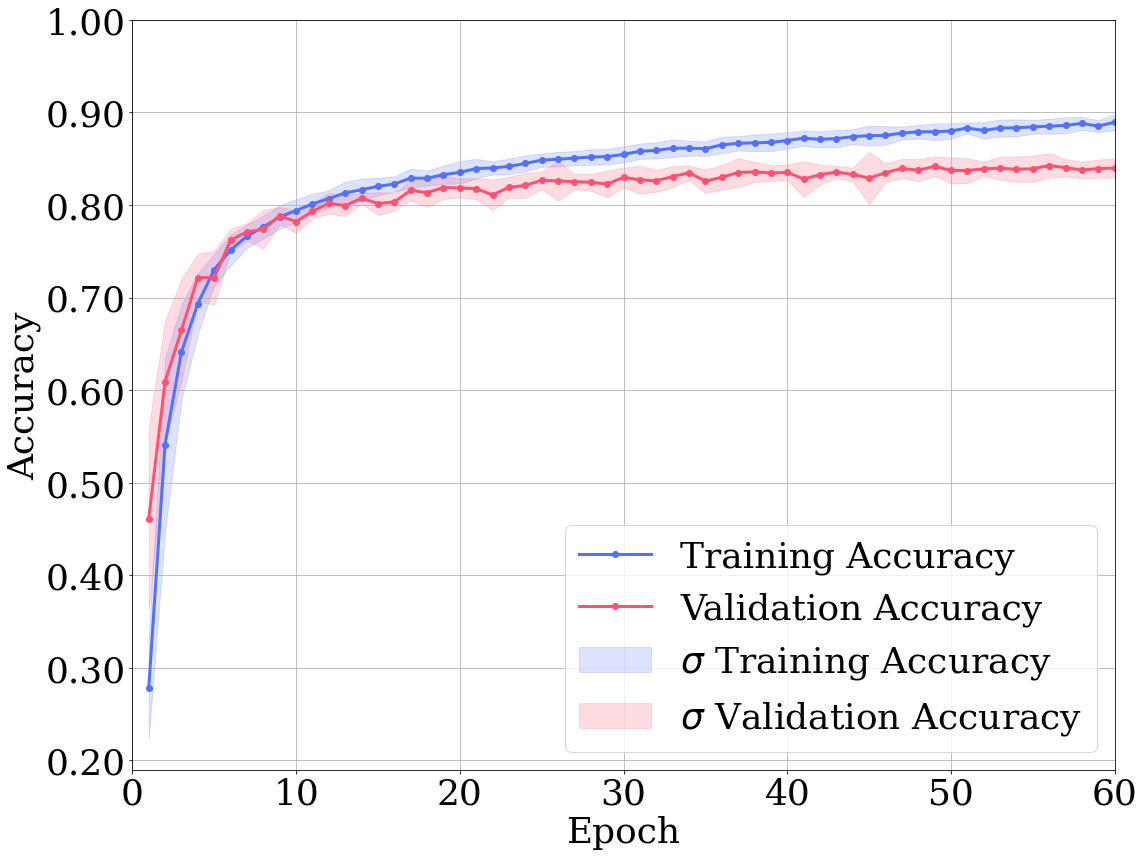

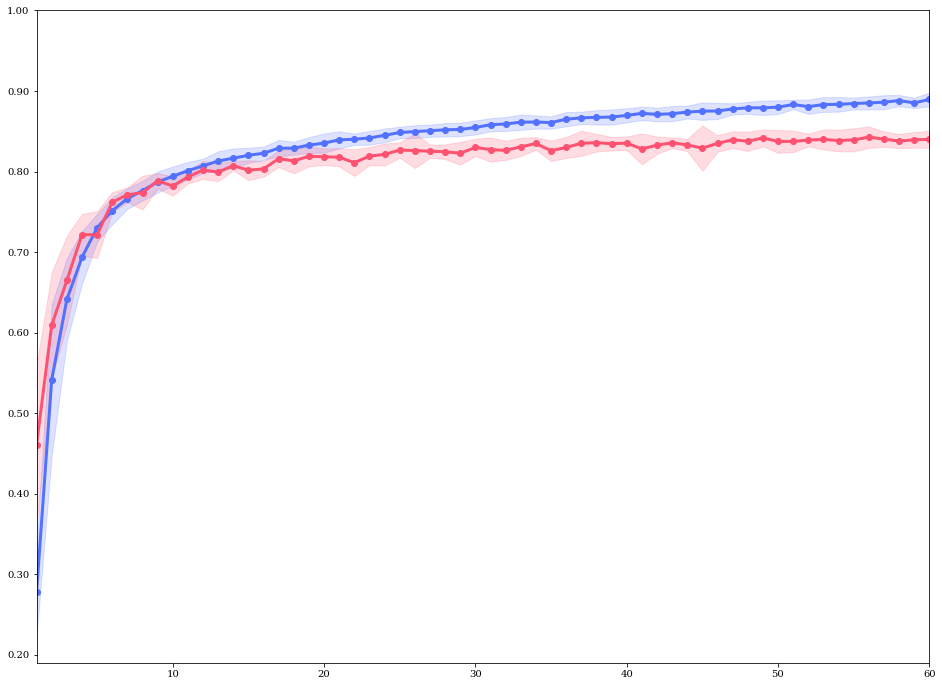

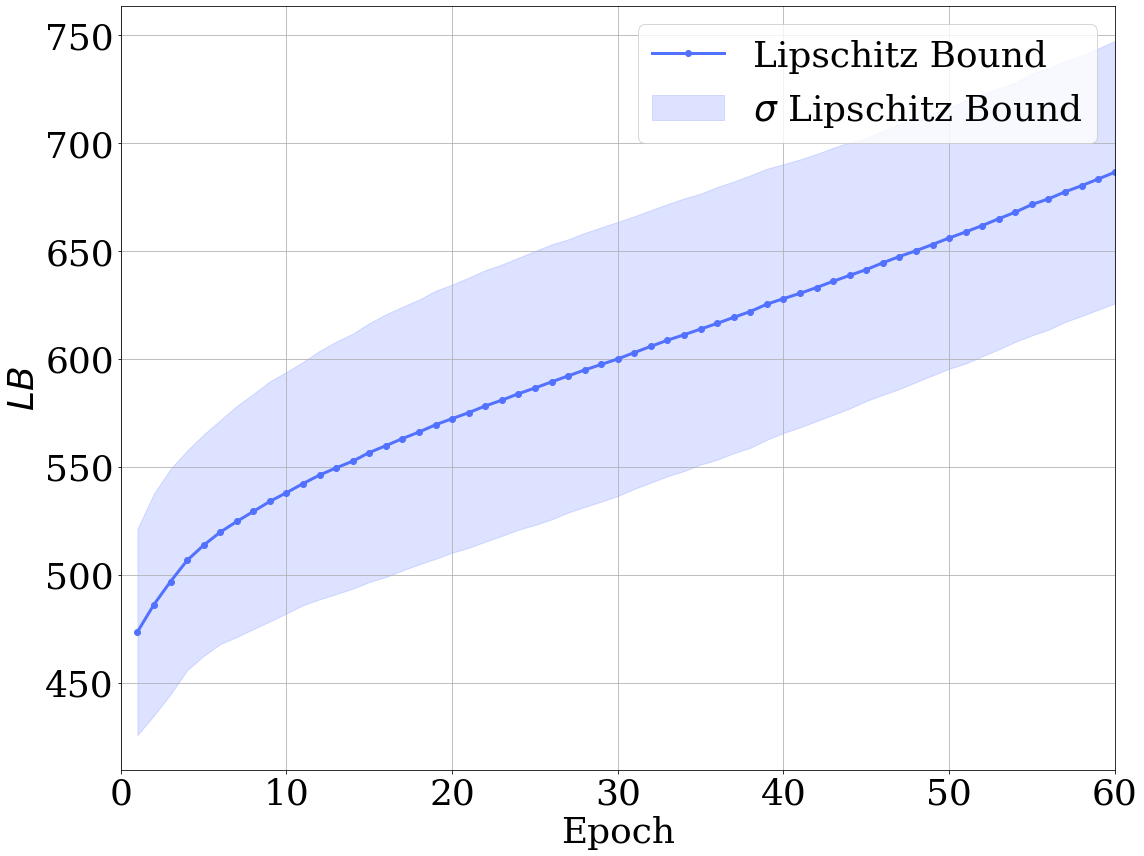

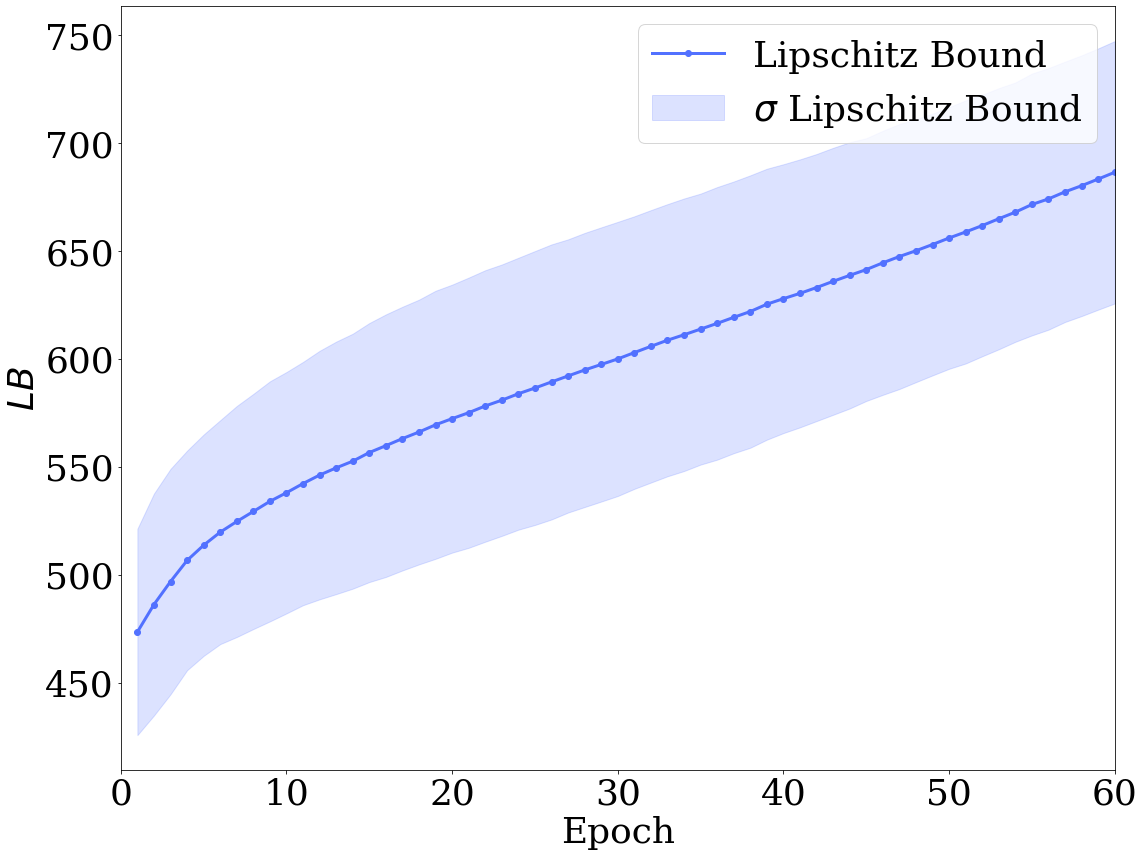

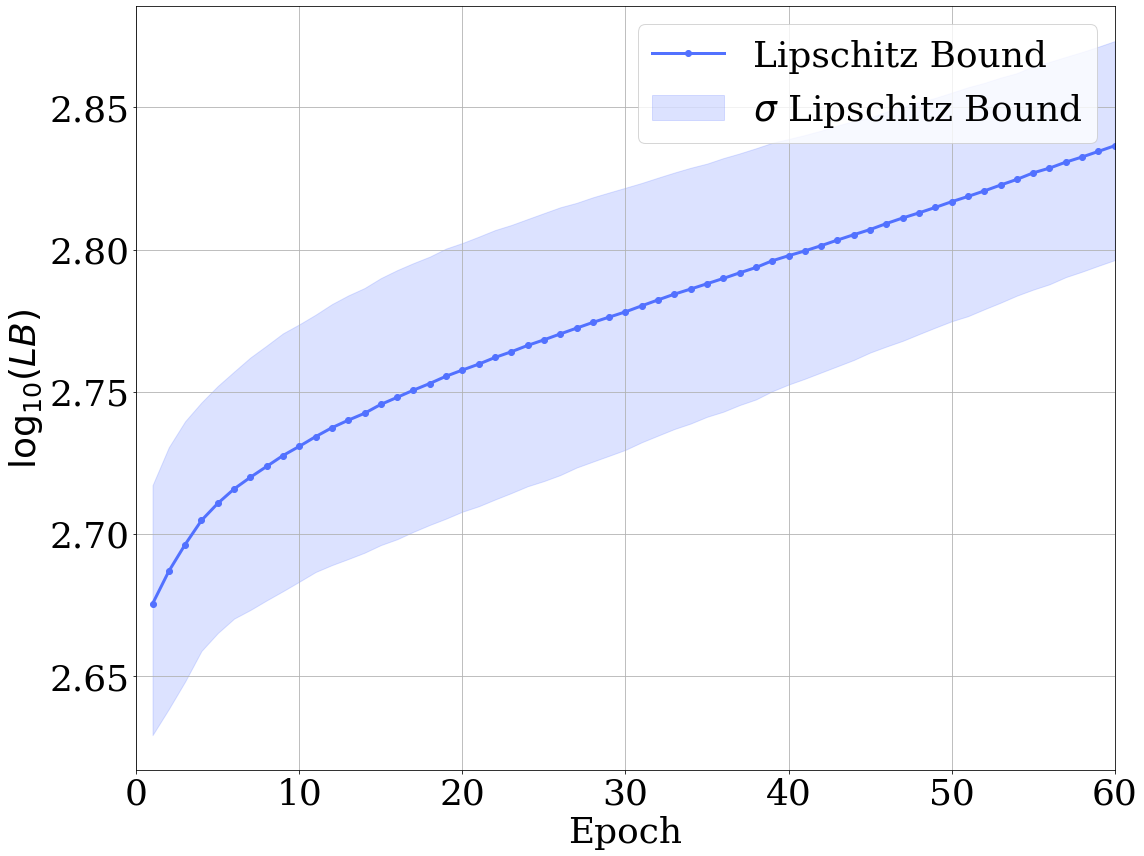

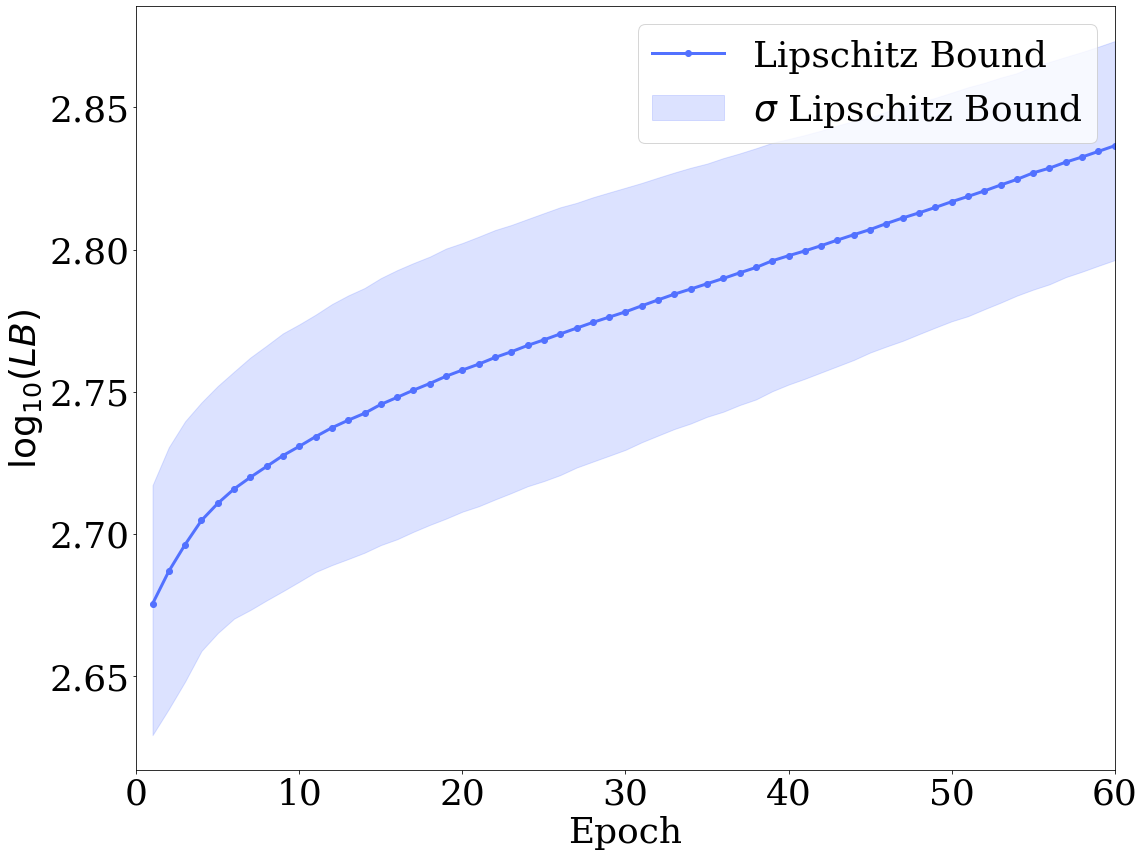

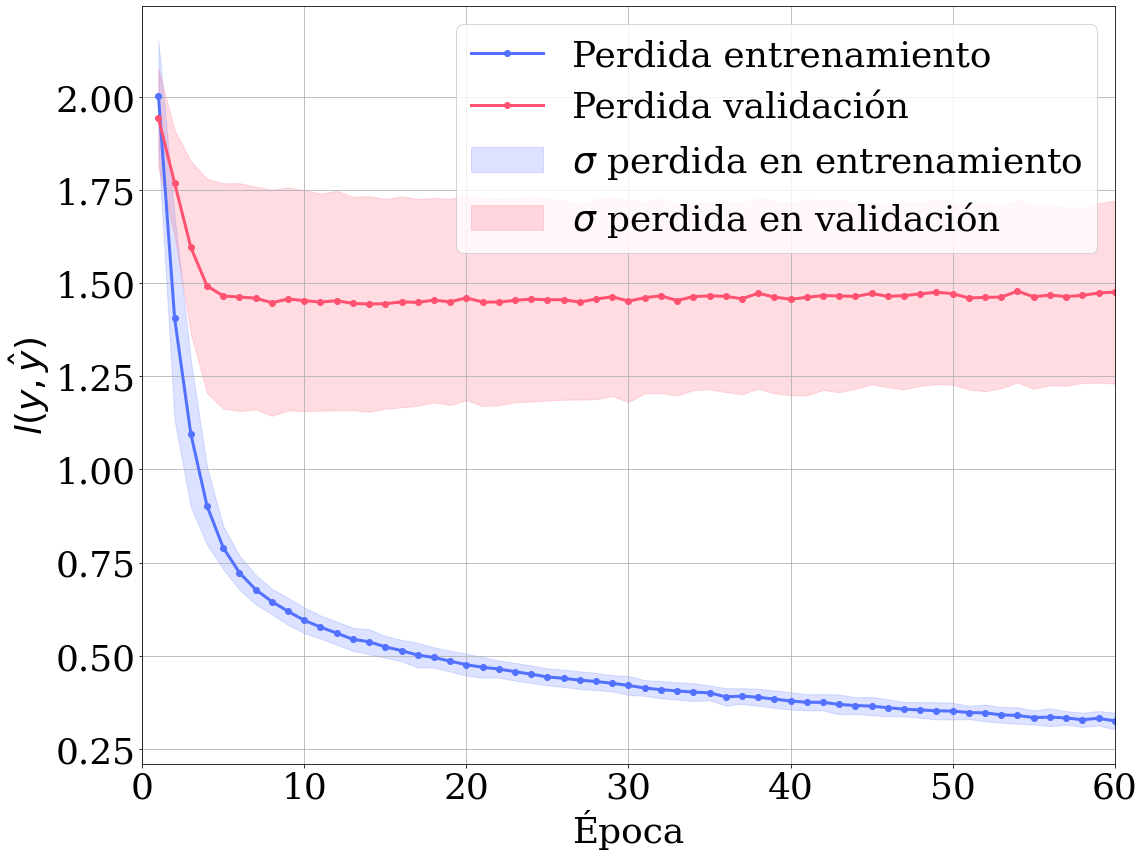

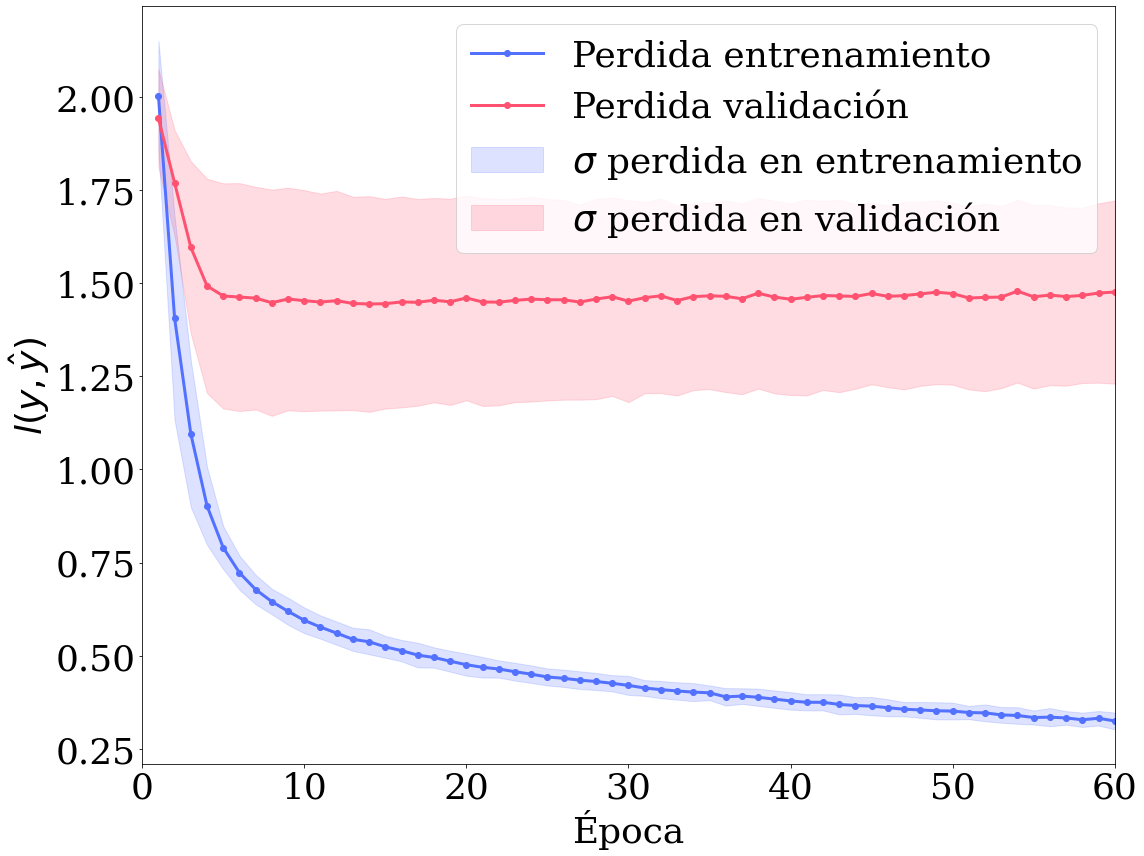

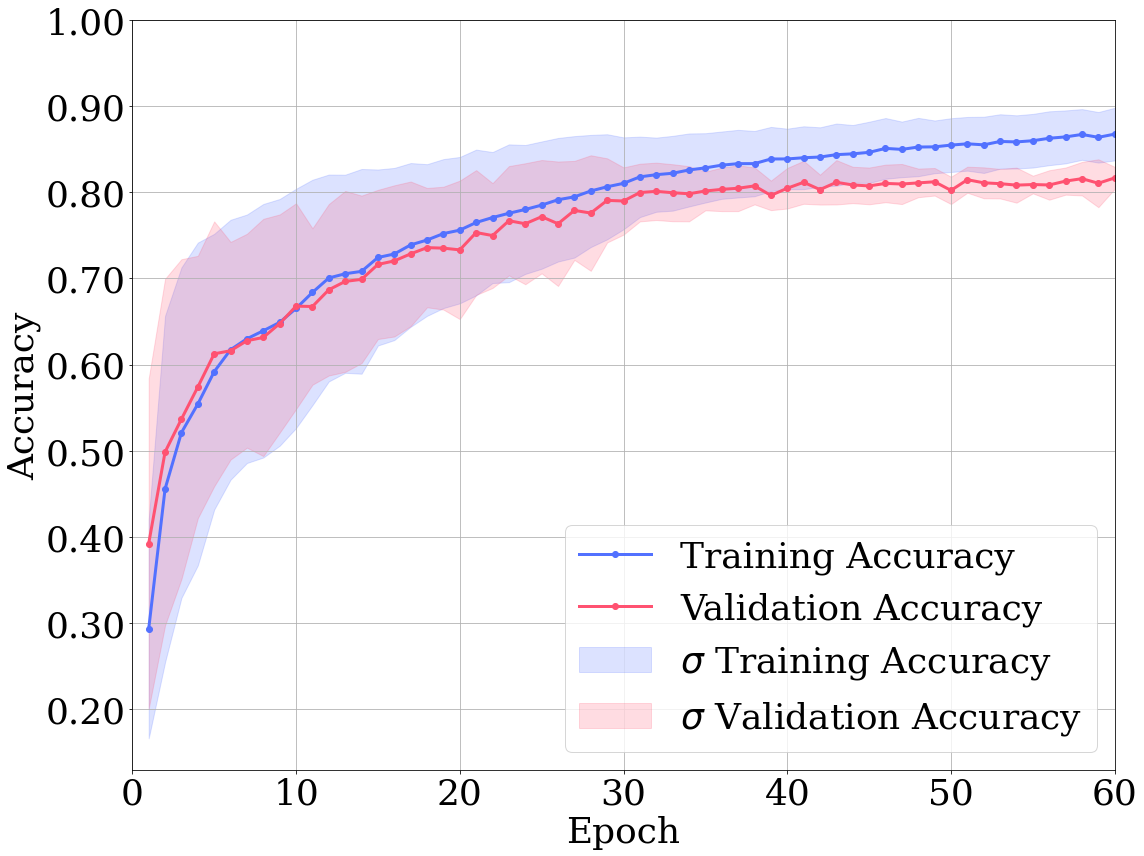

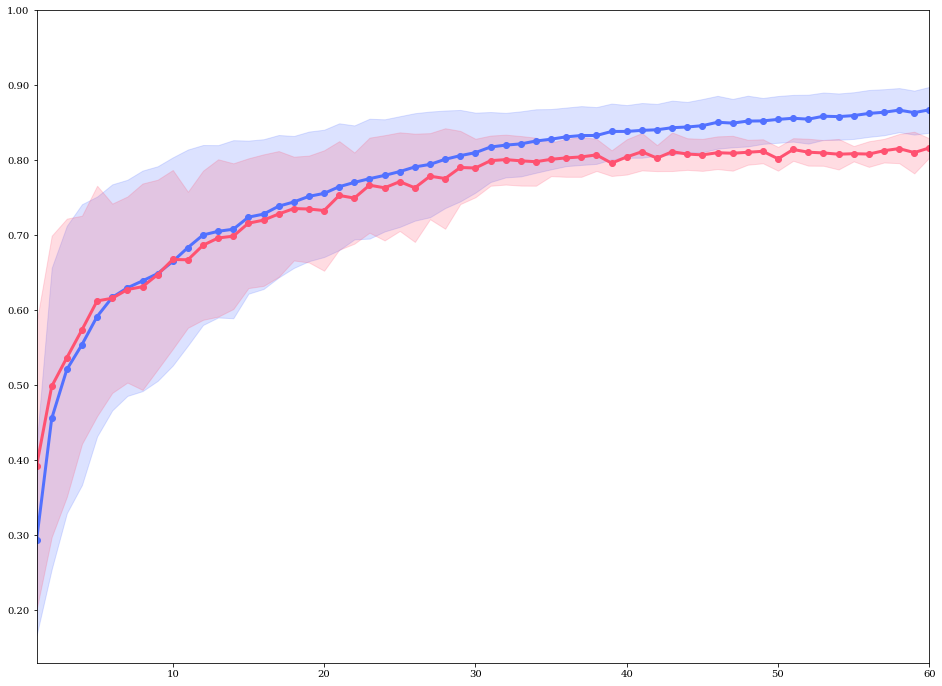

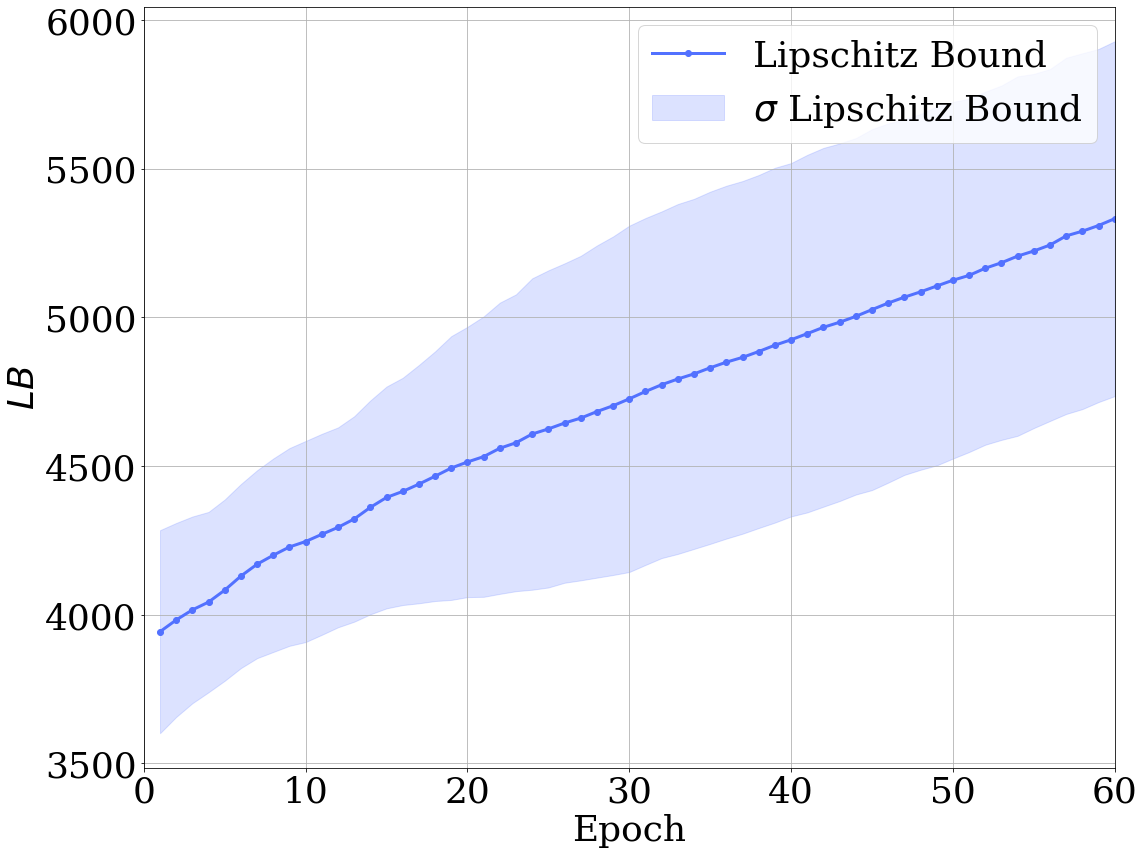

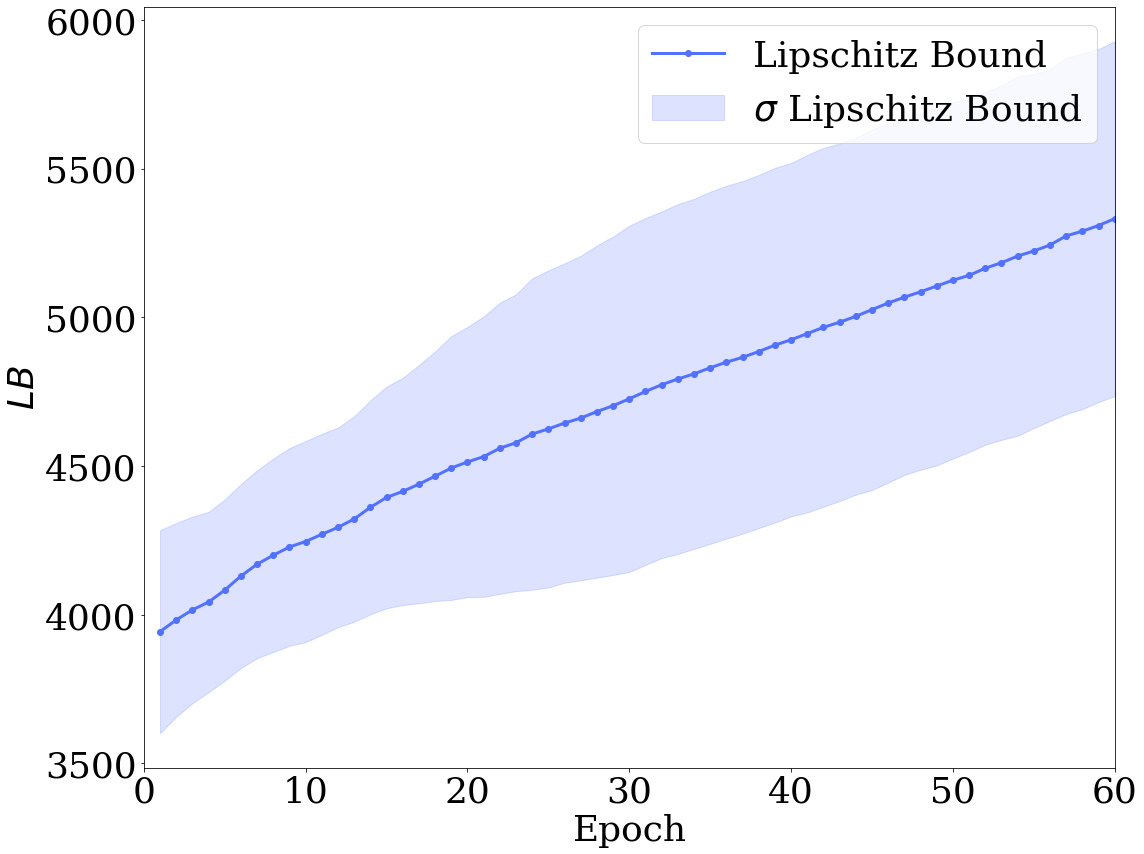

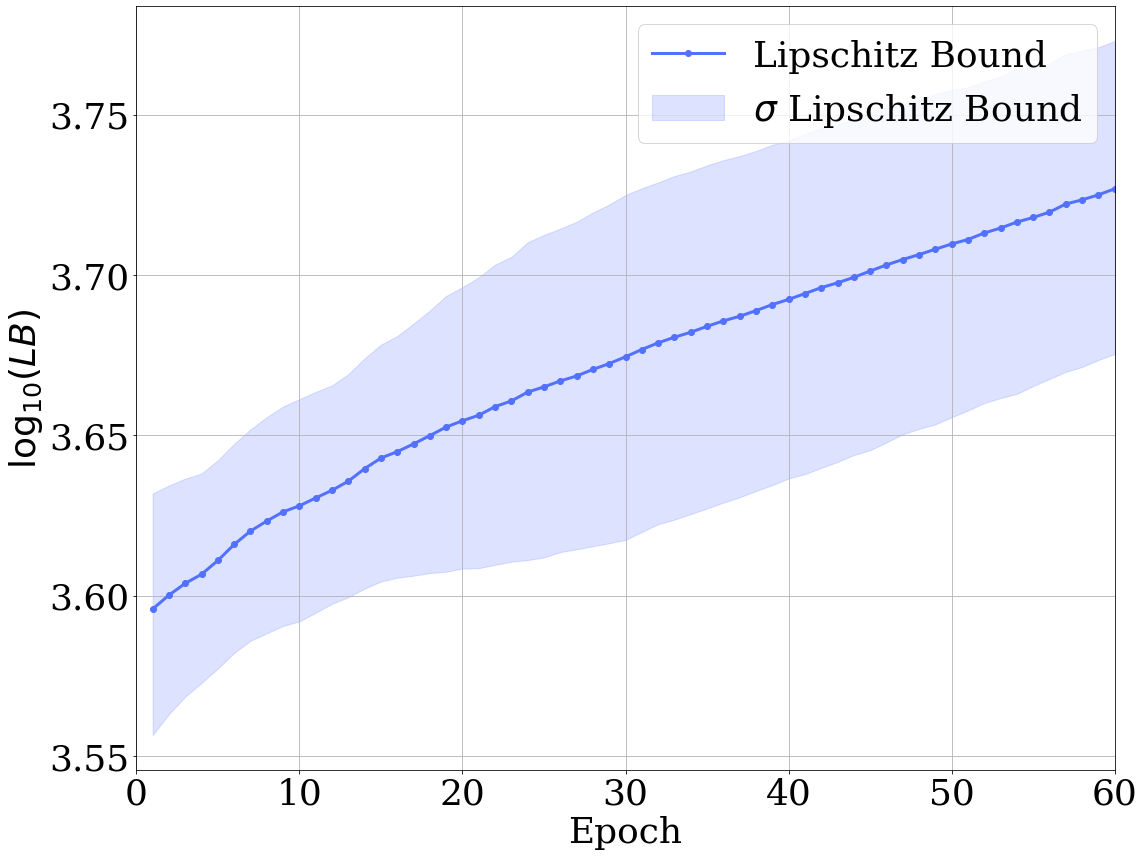

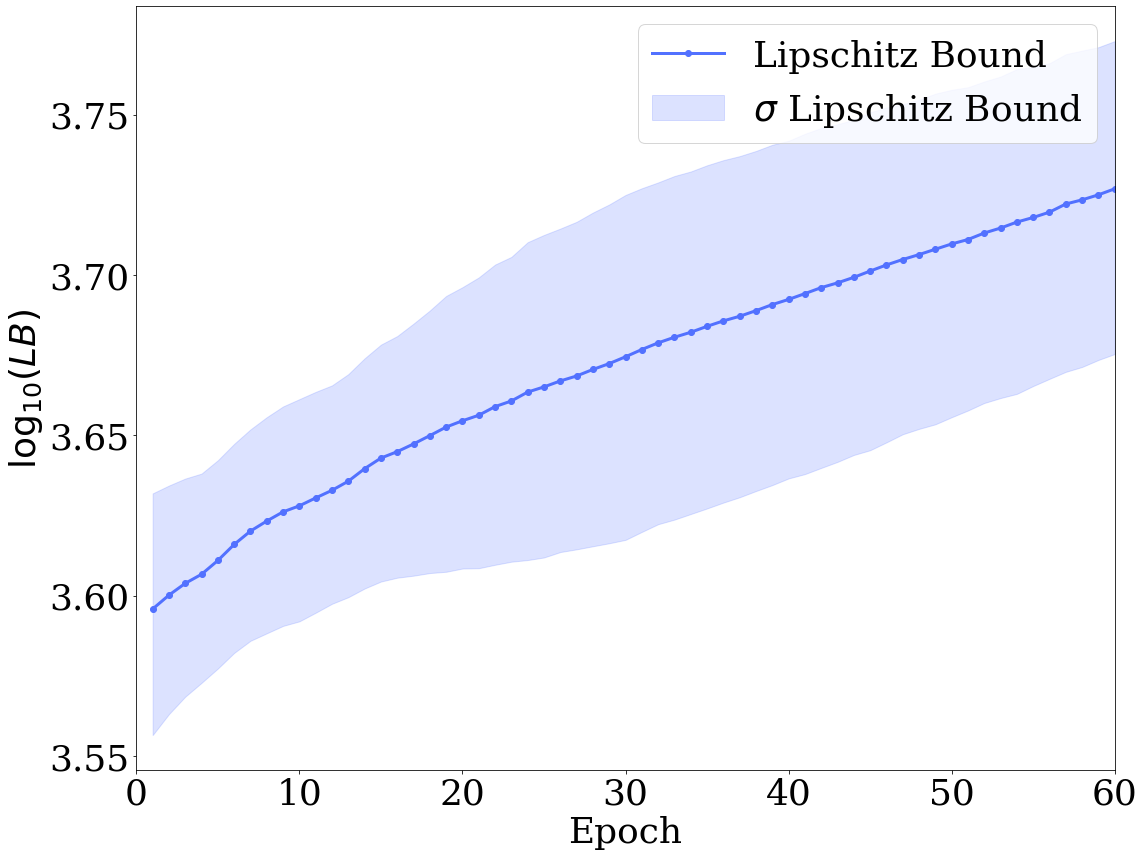

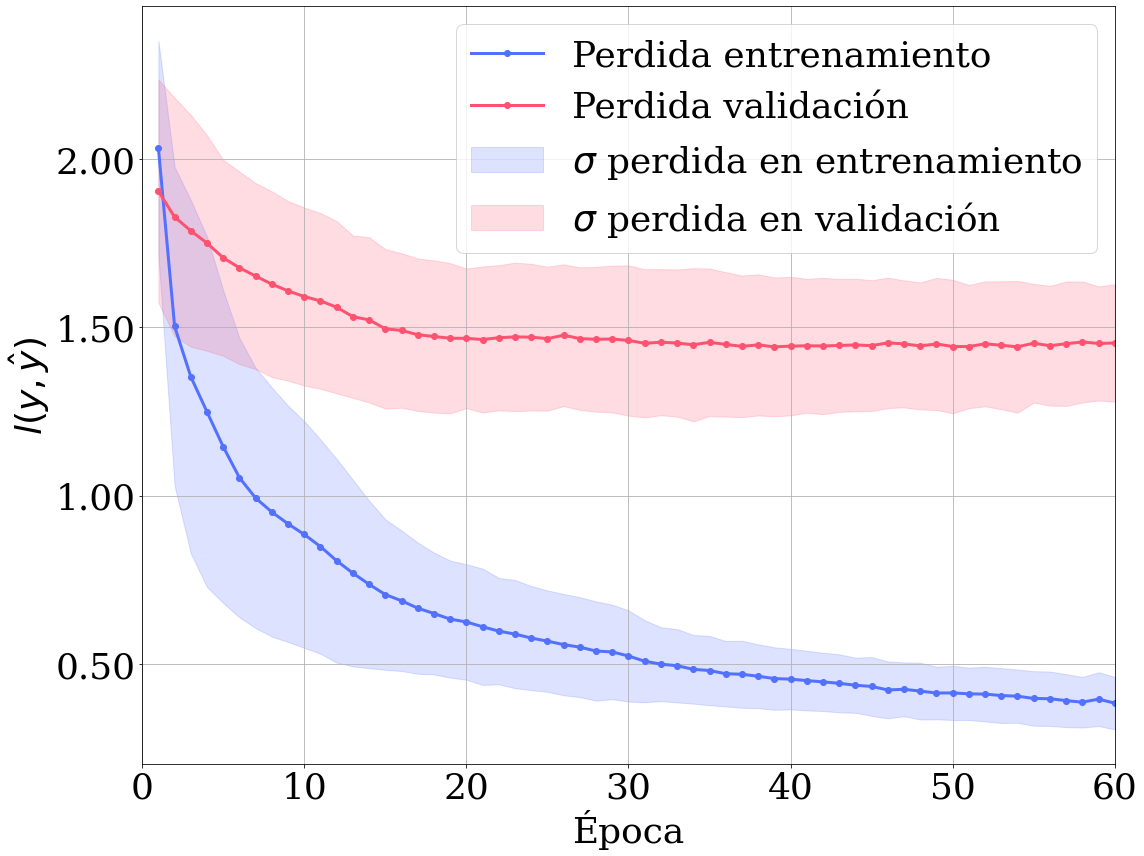

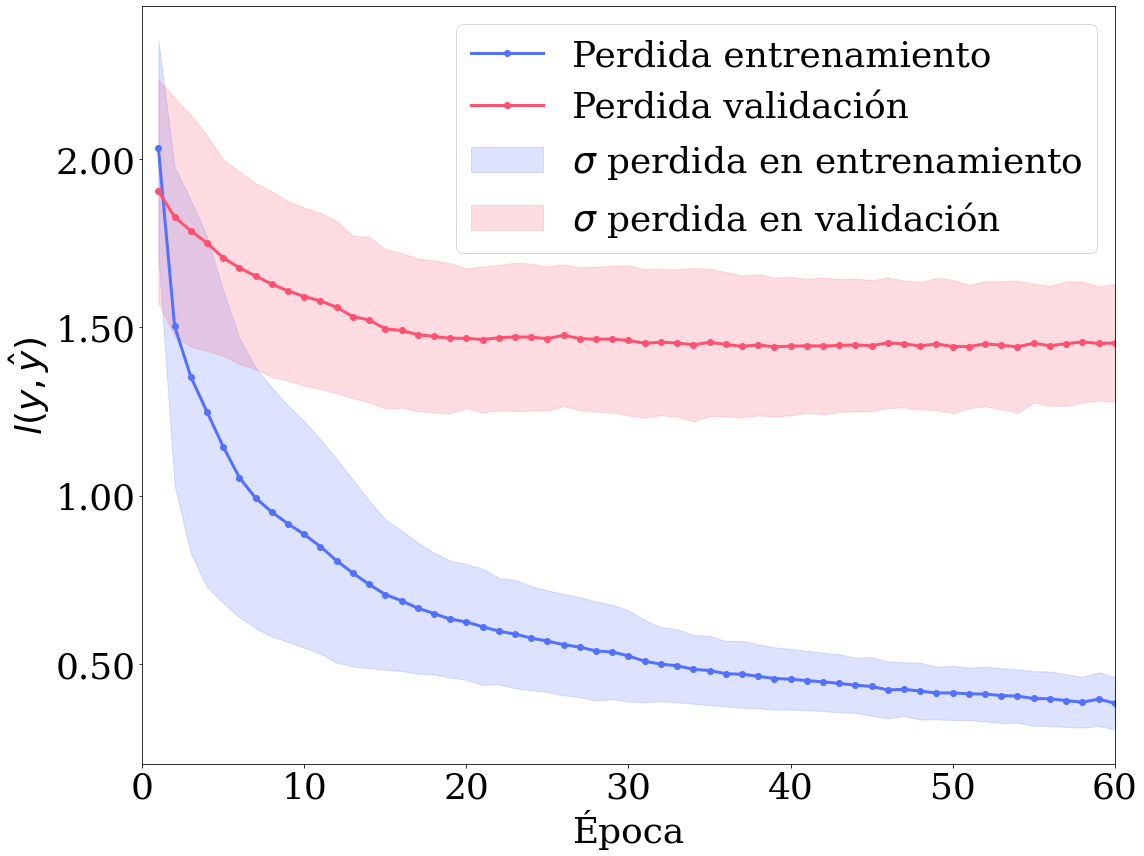

In [30]:
skips = [3,5,7]
n_epochs = 60
resultGeneralL2 = {}

for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []

  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,regularParameters[skip])
    model.compile(optimizer=optimizer, 
                  loss = tf.keras.losses.CategoricalCrossentropy(), 
                  metrics =['accuracy'])
    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
          loss += tf.add_n(model.losses)
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))

      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()
      
      y_ = model.predict(X_train[test_index], verbose=0) # Validation predictions

      loss_val[epoch] = ce_loss(y_true= keras.utils.to_categorical(y_train[test_index], num_classes=10), 
                                y_pred=y_).numpy()
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.argmax(y_, axis=-1))
      LB_1[epoch] = lipschitz_bound(model.get_weights())

    y_test_ = model(X_test)
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1)))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  # Diference train and validation
  diff_acc_mean = np.mean(acc_train_mean_M0 - acc_val_mean_M0)
  print('Mean diference train and validation')
  print(diff_acc_mean)
   
  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0
  # Area std train
  print('Area std train ')
  area_std_train = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_train_std_M0, k=1).integral(0,1)
  print(area_std_train)

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0
  # Area std test
  print('Area std test')
  area_std_test = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_val_std_M0, k=1).integral(0,1)
  print(area_std_test)

  graphGridAcc(skip)
  graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  graphGridLipschtiz(skip)
  graphLipschtiz(skip)
  graphGridLipschtizlog(skip)
  graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  graphGridLoss(skip)
  graphLoss(skip)

  resultGeneralL2[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralL2), 'ResultadosExperimentoALBL2.csv')

### Evaluación en test de los modelos

In [31]:
for skip in skips:
  mean_test = np.mean(resultGeneralL2[skip][5])
  std_test = np.std(resultGeneralL2[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 3, test 82.59 +/- 0.384
Modelo 5, test 82.94 +/- 0.852
Modelo 7, test 80.94 +/- 1.562


### Evaluación en entrenamiento de los modelos

In [32]:
for skip in skips:
  mean_train = np.mean([resultGeneralL2[skip][0][x][-1] for x in resultGeneralL2[skip][0]])
  std_train = np.std([resultGeneralL2[skip][0][x][-1] for x in resultGeneralL2[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 3, train 87.31 +/- 0.388
Modelo 5, train 88.95 +/- 0.760
Modelo 7, train 86.75 +/- 2.730


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L1

### Sintonización hiper-parámetro

In [33]:
skips = [3,5,7]
kf = KFold(n_splits=5, shuffle=False)

In [34]:
param_grid = [ l.l1(0.1), l.l1(0.01), l.l1(0.001), l.l1(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l1}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_model(skip,param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train_onehot[train_index],
                epochs = 20, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 3, parametro 0.10000000149011612
Kfold 1 acc train 0.10337500274181366, acc test 0.09700000286102295
Kfold 2 acc train 0.10300000011920929, acc test 0.0989999994635582
Kfold 3 acc train 0.10387499630451202, acc test 0.0949999988079071
Kfold 4 acc train 0.10300000011920929, acc test 0.09749999642372131
Kfold 5 acc train 0.10750000178813934, acc test 0.08349999785423279
Fin modelo: promedio acc train 0.10415000021457672,std 0.001705506330384162
Fin modelo: promedio acc test 0.09439999908208847,std 0.005598214592463632


Modelo 3, parametro 0.009999999776482582
Kfold 1 acc train 0.7451249957084656, acc test 0.75
Kfold 2 acc train 0.7477499842643738, acc test 0.7350000143051147
Kfold 3 acc train 0.7411249876022339, acc test 0.7455000281333923
Kfold 4 acc train 0.7606250047683716, acc test 0.7379999756813049
Kfold 5 acc train 0.7577499747276306, acc test 0.737500011920929
Fin modelo: promedio acc train 0.7504749894142151,std 0.00747554469724176
Fin modelo: promedio acc test 0.7412000

In [35]:
regularParameters = {3: l.l1(0.001), 5: l.l1(0.0001), 7: l.l1(0.0001)}
regularParameters

{3: <keras.regularizers.L1 at 0x7f4ef41c5970>,
 5: <keras.regularizers.L1 at 0x7f4ef41c5430>,
 7: <keras.regularizers.L1 at 0x7f4ef41c5610>}

### Entrenamiento

In [36]:
skips = [3,5,7]
n_epochs = 60
resultGeneralL1 = {}

for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []

  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,regularParameters[skip])
    model.compile(optimizer=optimizer, 
                  loss = tf.keras.losses.CategoricalCrossentropy(), 
                  metrics =['accuracy'])
    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
          loss += tf.add_n(model.losses)
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()
      
      y_ = model.predict(X_train[test_index], verbose=0) # Validation predictions

      loss_val[epoch] = ce_loss(y_true= keras.utils.to_categorical(y_train[test_index], num_classes=10), 
                                y_pred=y_).numpy()
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.argmax(y_, axis=-1))
      LB_1[epoch] = lipschitz_bound(model.get_weights())

    y_test_ = model(X_test)
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1)))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  # Diference train and validation
  diff_acc_mean = np.mean(acc_train_mean_M0 - acc_val_mean_M0)
  print('Mean diference train and validation')
  print(diff_acc_mean)
   
  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0
  # Area std train
  print('Area std train ')
  area_std_train = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_train_std_M0, k=1).integral(0,1)
  print(area_std_train)

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0
  # Area std test
  print('Area std test')
  area_std_test = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_val_std_M0, k=1).integral(0,1)
  print(area_std_test)

  #graphGridAcc(skip)
  #graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  #graphGridLipschtiz(skip)
  #graphLipschtiz(skip)
  #graphGridLipschtizlog(skip)
  #graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  #graphGridLoss(skip)
  #graphLoss(skip)

  resultGeneralL1[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralL1), 'ResultadosExperimentoALBL1.csv')

Modelo : 3 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 144.35397148132324 en k-fold 1
80
Tiempo total 145.15410494804382 en k-fold 2
80
Tiempo total 146.37915110588074 en k-fold 3
80
Tiempo total 144.81273436546326 en k-fold 4
80
Tiempo total 144.68311476707458 en k-fold 5
Mean diference train and validation
0.009498361713886268
Area std train 
0.06446586363017559
Area std test
0.07008686994840316
Modelo : 5 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 171.28836274147034 en k-fold 1
80
Tiempo total 170.23070454597473 en k-fold 2
80
Tiempo total 171.709135055542 en k-fold 3
80
Tiempo total 164.66702342033386 en k-fold 4
80
Tiempo total 160.25064039230347 en k-fold 5
Mean diference train and validation
0.023776693603992483
Area std train 
0.11544973403215408
Area std t

### Evaluación en test de los modelos

In [37]:
for skip in skips:
  mean_test = np.mean(resultGeneralL1[skip][5])
  std_test = np.std(resultGeneralL1[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 3, test 82.78 +/- 0.496
Modelo 5, test 82.50 +/- 0.168
Modelo 7, test 79.51 +/- 2.007


### Evaluación en entrenamiento de los modelos

In [38]:
for skip in skips:
  mean_train = np.mean([resultGeneralL1[skip][0][x][-1] for x in resultGeneralL1[skip][0]])
  std_train = np.std([resultGeneralL1[skip][0][x][-1] for x in resultGeneralL1[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 3, train 85.92 +/- 0.380
Modelo 5, train 88.73 +/- 1.019
Modelo 7, train 86.30 +/- 2.613


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método *Dropout*

### Modelo DropOut

In [39]:
from keras.layers.regularization.dropout import Dropout

def skip_conectionDropOut(dense_input, n, regular_l, probabilityDrop):
  if n >= 2:
    resDense = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
    resDenseDropOut = Dropout((probabilityDrop))(resDense)
    return skip_conection(Add()([dense_input, resDenseDropOut]), n-1, regular_l)
  resDenseo = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
  resDenseoDropOut = Dropout((probabilityDrop))(resDenseo)
  return Add()([dense_input, resDenseo])

In [40]:
def load_modelDropOut(n, regular_l, probabilityDrop):
  keras.backend.clear_session()
  inputs  = Input(shape=(784,))
  dense1  = Dense(20,  activation  ='relu', kernel_regularizer=regular_l)(inputs)
  dense1DropOut = Dropout((probabilityDrop))(dense1)
  skip_final = skip_conectionDropOut(dense1DropOut, n, regular_l, probabilityDrop)

  outputs = Dense(10, activation='sigmoid', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

### Sintonización hiper-parámetro

In [41]:
skips = [3,5,7]
kf = KFold(n_splits=5, shuffle=False)

In [42]:
param_grid = [ 0.2, 0.4, 0.6, 0.8]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_modelDropOut(skip, l.l2(0), param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train_onehot[train_index],
                epochs = 20, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 3, parametro 0.2
Kfold 1 acc train 0.8512499928474426, acc test 0.8389999866485596
Kfold 2 acc train 0.8395000100135803, acc test 0.8025000095367432
Kfold 3 acc train 0.8511250019073486, acc test 0.8410000205039978
Kfold 4 acc train 0.8387500047683716, acc test 0.8174999952316284
Kfold 5 acc train 0.8554999828338623, acc test 0.8205000162124634
Fin modelo: promedio acc train 0.8472249984741211,std 0.00680274852785843
Fin modelo: promedio acc test 0.8241000056266785,std 0.014357575208846944


Modelo 3, parametro 0.4
Kfold 1 acc train 0.8107500076293945, acc test 0.8069999814033508
Kfold 2 acc train 0.8168749809265137, acc test 0.7935000061988831
Kfold 3 acc train 0.7908750176429749, acc test 0.7820000052452087
Kfold 4 acc train 0.7591249942779541, acc test 0.7294999957084656
Kfold 5 acc train 0.8368750214576721, acc test 0.7979999780654907
Fin modelo: promedio acc train 0.8029000043869019,std 0.02635175941518545
Fin modelo: promedio acc test 0.7819999933242798,std 0.0274572357000

In [43]:
regularParameters = {3: 0.2, 5: 0.2, 7: 0.2}
regularParameters

{3: 0.2, 5: 0.2, 7: 0.2}

### Entrenamiento

In [44]:
skips = [3,5,7]
n_epochs = 60
resultGeneralDO = {}

for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []

  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_modelDropOut(skip,l.l2(0),regularParameters[skip])
    model.compile(optimizer=optimizer, 
                  loss = tf.keras.losses.CategoricalCrossentropy(), 
                  metrics =['accuracy'])
    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      
      for batch in range(n_batches):
        x, y = generator[batch]
        
        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()
      
      y_ = model.predict(X_train[test_index], verbose=0) # Validation predictions

      loss_val[epoch] = ce_loss(y_true= keras.utils.to_categorical(y_train[test_index], num_classes=10), 
                                y_pred=y_).numpy()
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.argmax(y_, axis=-1))
      LB_1[epoch] = lipschitz_bound(model.get_weights())

    y_test_ = model(X_test)
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1)))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  # Diference train and validation
  diff_acc_mean = np.mean(acc_train_mean_M0 - acc_val_mean_M0)
  print('Mean diference train and validation')
  print(diff_acc_mean)
   
  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0
  # Area std train
  print('Area std train ')
  area_std_train = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_train_std_M0, k=1).integral(0,1)
  print(area_std_train)

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0
  # Area std test
  print('Area std test')
  area_std_test = interpolate.InterpolatedUnivariateSpline(range(n_epochs), acc_val_std_M0, k=1).integral(0,1)
  print(area_std_test)
  #graphGridAcc(skip)
  #graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  # graphGridLipschtiz(skip)
  # graphLipschtiz(skip)
  # graphGridLipschtizlog(skip)
  # graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  # graphGridLoss(skip)
  # graphLoss(skip)

  resultGeneralDO[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralDO), 'ResultadosExperimentoALBDO.csv')

Modelo : 3 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 120.52617907524109 en k-fold 1
80
Tiempo total 121.80375027656555 en k-fold 2
80
Tiempo total 118.57306575775146 en k-fold 3
80
Tiempo total 119.87670135498047 en k-fold 4
80
Tiempo total 118.43912172317505 en k-fold 5
Mean diference train and validation
-0.06142499112288157
Area std train 
0.046010980382561684
Area std test
0.0766409304200516
Modelo : 5 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
80
Tiempo total 135.2499668598175 en k-fold 1
80
Tiempo total 136.69537711143494 en k-fold 2
80
Tiempo total 135.48493242263794 en k-fold 3
80
Tiempo total 135.47732305526733 en k-fold 4
80
Tiempo total 135.5182819366455 en k-fold 5
Mean diference train and validation
-0.06452168060342471
Area std train 
0.09354633465409279
Area std t

### Evaluación en test de los modelos

In [45]:
for skip in skips:
  mean_test = np.mean(resultGeneralDO[skip][5])
  std_test = np.std(resultGeneralDO[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 3, test 82.03 +/- 0.350
Modelo 5, test 75.19 +/- 8.161
Modelo 7, test 74.63 +/- 5.988


### Evaluación en entrenamiento de los modelos

In [46]:
for skip in skips:
  mean_train = np.mean([resultGeneralDO[skip][0][x][-1] for x in resultGeneralDO[skip][0]])
  std_train = np.std([resultGeneralDO[skip][0][x][-1] for x in resultGeneralDO[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 3, train 79.74 +/- 1.090
Modelo 5, train 72.61 +/- 9.874
Modelo 7, train 72.61 +/- 5.986


## Gráficas conjuntas

In [57]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

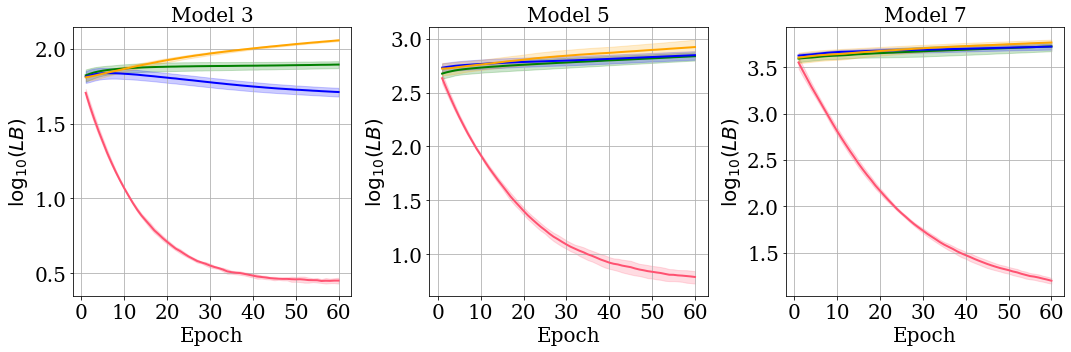

In [58]:
n_epochs = 60
fig, ax = plt.subplots(nrows=1, ncols=3, 
                       sharex=True, 
                       figsize=(15, 5))

for axis in ax:
  axis.set_xticks(np.arange(0, n_epochs+1, step=10))
  axis.set_ylabel(r'$\log_{10} (LB)$',fontsize=20)
  axis.set_xlabel('Epoch',fontsize=20)
for axis, col in zip(ax, ['Model 3', 'Model 5', 'Model 7']):
    axis.set_title(col, fontsize=20)

for axis, skip in zip(ax,[3,5,7]): # LB
  
  Kf_LB_M0 = resultGeneral[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, np.log10(LB_mean_M0), '#ff5271', linestyle = "-",
           label='Lipschitz Bound', lw = 2)
  axis.fill_between(epoch_vec, np.log10(LB_std_positive_M0),
                    np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = '#ff5271',
                  label = r'$\sigma$ Lipschitz Bound')

  Kf_LB_M0 = resultGeneralL2[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, np.log10(LB_mean_M0), 'g', linestyle = "-", 
           label='Lipschitz Bound', lw = 2)
  axis.fill_between(epoch_vec, np.log10(LB_std_positive_M0),
                    np.log10(LB_std_negative_M0), 
                   alpha=0.2, color='g',
                  label = r'$\sigma$ Lipschitz Bound')
  
  Kf_LB_M0 = resultGeneralL1[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, np.log10(LB_mean_M0), 'blue',linestyle = "-",
           label='Lipschitz Bound', lw = 2)
  axis.fill_between(epoch_vec, np.log10(LB_std_positive_M0),
                    np.log10(LB_std_negative_M0), 
                   alpha=0.2, color =  'blue',
                  label = r'$\sigma$ Lipschitz Bound')

  Kf_LB_M0 = resultGeneralDO[skip][4] 
  
  epoch_vec = range(1,n_epochs+1)
  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  axis.plot(epoch_vec, np.log10(LB_mean_M0), 'orange', linestyle = "-",
           label='Lipschitz Bound', lw = 2)
  axis.fill_between(epoch_vec, np.log10(LB_std_positive_M0),
                    np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = 'orange',
                  label = r'$\sigma$ Lipschitz Bound')

  axis.grid()

plt.tight_layout()
plt.savefig('LBB.pdf')

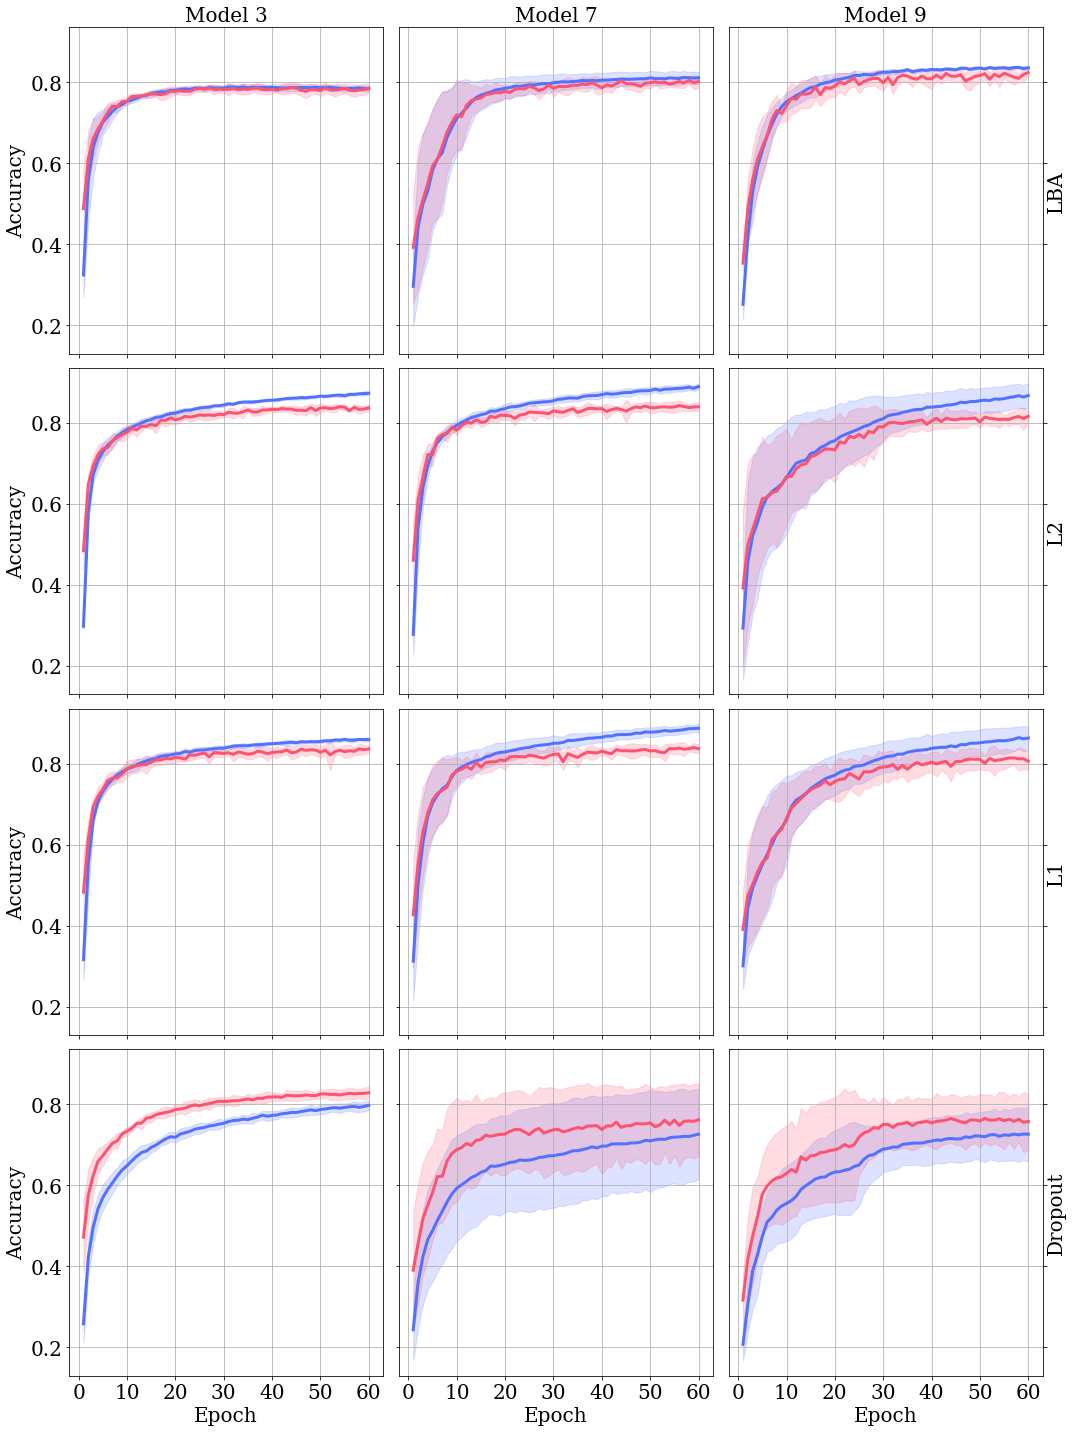

In [61]:
n_epochs = 60
fig, ax = plt.subplots(nrows=4, ncols=3, 
                       sharex=True, sharey=True, 
                       figsize=(15, 20))

for i in range(4):
  for j in range(3):
    ax[i][j].set_xticks(np.arange(0, n_epochs+1, step=10))
    
for axis, skip in zip(ax[0],[3,5,7]): # LB
  
  Kf_eval_train_M0 = resultGeneral[skip][0] 
  Kf_eval_val_M0 = resultGeneral[skip][1] 
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  axis.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-",
           label='Training Accuracy', lw = 3)
  axis.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
          label='Validation Accuracy', linestyle = '-', lw = 3)
  axis.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                  label = r'$\sigma$ Training Accuracy',
                alpha=0.2, color = '#5271ff')
  axis.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                  label = r'$\sigma$ Validation Accuracy',
                alpha=0.2, color = '#ff5271')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, skip in zip(ax[1],[3,5,7]): # L2
  
  Kf_eval_train_M0 = resultGeneralL2[skip][0] 
  Kf_eval_val_M0 = resultGeneralL2[skip][1] 
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  axis.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-",
           label='Training Accuracy', lw = 3)
  axis.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
          label='Validation Accuracy', linestyle = '-', lw = 3)
  axis.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                  label = r'$\sigma$ Training Accuracy',
                alpha=0.2, color = '#5271ff')
  axis.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                  label = r'$\sigma$ Validation Accuracy',
                alpha=0.2, color = '#ff5271')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, skip in zip(ax[2],[3,5,7]): # L1
  
  Kf_eval_train_M0 = resultGeneralL1[skip][0] 
  Kf_eval_val_M0 = resultGeneralL1[skip][1] 
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  axis.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-",
           label='Training Accuracy', lw = 3)
  axis.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
          label='Validation Accuracy', linestyle = '-', lw = 3)
  axis.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                  label = r'$\sigma$ Training Accuracy',
                alpha=0.2, color = '#5271ff')
  axis.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                  label = r'$\sigma$ Validation Accuracy',
                alpha=0.2, color = '#ff5271')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, skip in zip(ax[3],[3,5,7]): # DO
  
  Kf_eval_train_M0 = resultGeneralDO[skip][0] 
  Kf_eval_val_M0 = resultGeneralDO[skip][1] 
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  axis.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-",
           label='Training Accuracy', lw = 3)
  axis.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
          label='Validation Accuracy', linestyle = '-',lw = 3)
  axis.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                  label = r'$\sigma$ Training Accuracy',
                alpha=0.2, color = '#5271ff')
  axis.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                  label = r'$\sigma$ Validation Accuracy',
                alpha=0.2, color = '#ff5271')
  axis.grid()
  #axis.xlim([1, n_epochs])
  #axis.ylim(top=1)

for axis, col in zip(ax[0], ['Model 3', 'Model 7', 'Model 9']):
    axis.set_title(col, fontsize=20)

for axis in ax[3]:
  axis.set_xlabel('Epoch', fontsize = 20)

for axis in ax[:,0]:
  axis.set_ylabel('Accuracy', fontsize = 20)

for axis, row in zip(ax[:,2], ['LBA', 'L2', 'L1', 'Dropout']):
    axis.set_ylabel(row, rotation=90, fontsize=20)
    axis.yaxis.set_label_position("right")
    axis.yaxis.tick_right()
    axis = plt.gca()
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
#plt.savefig('AccEB.pdf')